# Рекомендация актуальных тарифов

#### Тема проекта:
- Рекомендация оптимального тарифа из актуальных тарифных планов

#### Цель:
- Построить модель для задачи классификации, рекомендующую оптимальный тариф

#### Поставленные задачи:
- Исследовать предоставленные данные (предобработка не требуется);
- Рассмотреть несколько моделей (решающее дерево, случайный лес, логистическая регрессия);
- Протестировать модели с наилучшими гиперпараметрами на тестовой выборке;
- Получить значение *accuracy* не ниже 0.75.

#### Краткий план работы:
- [Шаг 1. Открытие и изучение файла](#Шаг-1.-Открытие-и-изучение-файла)
- [Шаг 2. Исследование моделей](#Шаг-2.-Исследование-моделей)
  - [1. Решающее дерево (DecisionTreeClassifier)](#1.-Решающее-дерево-(DecisionTreeClassifier))
  - [2. Случайный лес (RandomForestClassifier)](#2.-Случайный-лес-(RandomForestClassifier))
  - [3. Логистическая регрессия (LogisticRegression)](#3.-Логистическая-регрессия-(LogisticRegression))
- [Шаг 3. Проверка моделей на тестовой выборке](#Шаг-3.-Проверка-моделей-на-тестовой-выборке)


#### Вывод:
- Исследованы предоставленные данные;
- Выбраны модели с наилучшими гиперпараметрами;
- На тестовой выборке получено значение *accuracy* не ниже 0.75.

**Статус проекта**: проект завершён.

**Используемые библиотеки**: *numpy*, *pandas*, *matplotlib*, *seaborn*, *sklearn*

**Источник данных**: [курс Data Science от Яндекс.Практикум](https://praktikum.yandex.ru/profile/data-scientist/)

In [1]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотек и функция для дальнейшей работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Шаг 1. Открытие и изучение файла

Выгрузим исходные данные и посмотрим по ним общую информацию. Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно, что файл предобработан, поэтому пропусков, дубликатов и аномальных значений не ожидается.  

In [2]:
# выгрузка исходных данных
users_behavior = pd.read_csv('datasets/users_behavior.csv')
users_behavior.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
# вывод общей информации
users_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В данных содержится **3214 строк** и **5 столбцов**:
- *сalls* — количество звонков,
- *minutes* — суммарная длительность звонков в минутах,
- *messages* — количество sms-сообщений,
- *mb_used* — израсходованный интернет-трафик в Мб,
- *is_ultra* — наименование тарифа ("Ультра" — 1, "Смарт" — 0).

Изучим, как обычно пользуются услугами пользователи тарифов "Смарт" и "Ультра". Посмотрим на **"усредненный портрет" пользователя** каждого из тарифов в нашей выборке. 

In [4]:
def box_describe(df_name, col_val, col_groupby, figsize=(7, 6), title=None,
                 xlabel='Тариф (0 - Смарт, 1 - Ультра)', ylabel=None, yticks=None, describe=True):
    
    """Функция возвращает боксплот и сводную статистику:
    - df_name - наименование датафрейма;
    - col_val - колонка со значениями;
    - col_groupby - колонка для группировки;
    - figsize - значение figsize;
    - title - значение title;
    - xlabel (по умолчанию 'Тариф (0 - Смарт, 1 - Ультра)') - значение xlabel;
    - ylabel - значение ylabel;
    - yticks - значение yticks;
    - describe (по умолчанию True) - нужно ли выводить сводную статистику."""
    
    # построение боксплот
    df_name.boxplot(col_val, by=col_groupby, figsize=figsize)
    plt.title(title)
    plt.xlabel('Тариф (0 - Смарт, 1 - Ультра)')
    plt.ylabel(ylabel)
    plt.yticks(yticks)
    plt.show()
    
    if describe:
        # вывод сводной статистики
        df_describe = df_name.groupby(col_groupby)[col_val].describe()
        return df_describe

#### 1. Количество звонков

Изучим данные по количеству звонков для каждого тарифа:

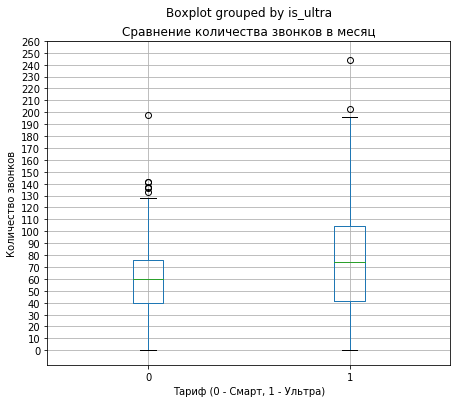

,count,mean,std,min,25%,50%,75%,max
is_ultra,,,,,,,,
0,2229.0,58.463437,25.939858,0.0,40.0,60.0,76.0,198.0
1,985.0,73.392893,43.916853,0.0,41.0,74.0,104.0,244.0


In [5]:
# количество звонков
box_describe(users_behavior, 'calls', 'is_ultra', title='Сравнение количества звонков в месяц',
             ylabel='Количество звонков', yticks=np.arange(0, 261, 10))

- Более **широкий размах** наблюдается для тарифа **Ультра**: в среднем люди делают **от 41 до 104 звонков** (половина всех наблюдений выборки по Ультра). По тарифу **Смарт** половина приходится на диапазон от **40 до 76 звонков**.

- **Выбросов** по количеству звонков довольно мало, **среднее** и **медиана** по обоим тарифам похожи: **58 и 60 звонков** соответственно для **Смарт** и **73 и 74 звонка** для тарифа **Ультра**.

- Встречаются **минимальные значения** равные **0 звонкам**, т. е. в этом месяце клиент **не пользовался услугой**.

- **Максимальное** количество звонков для тарифа **Ультра** - **244 звонка** за месяц, для **Смарт** - **198 звонков**.

Посмотрим, сколько всего в выборке нулевых звонков, т. е. *calls* равно 0:

In [6]:
def zero_count(df_name, col_val, col_val_name):
    
    """Функция выводит количество нулевых значений по тарифам:
    - df_name - наименование датафрейма;
    - col_val - колонка со значениями;
    - col_val_name - название параметра (колонки)."""
    
    len_total = len(df_name[df_name[col_val] == 0])
    ultra_total = df_name[df_name[col_val] == 0]['is_ultra'].sum()
    smart_total = len_total - ultra_total
    
    print(f'Количество нулевых значений ({col_val_name}):', len_total)
    print(f'Количество нулевых значений, тариф Ультра ({col_val_name}):', ultra_total)
    print(f'Количество нулевых значений, тариф Смарт ({col_val_name}):', smart_total)

In [7]:
# количество звонков
zero_count(users_behavior, 'calls', 'звонки')

Количество нулевых значений (звонки): 40
Количество нулевых значений, тариф Ультра (звонки): 34
Количество нулевых значений, тариф Смарт (звонки): 6


- Из **40 нулевых** звонков **34 наблюдения** (порядка 85%) приходится на **пользователей Ультра**.  
И это с учётом того, что пользователей Ультра в принципе **меньше** в выборке, чем пользователей Смарт.

Посмотрим на распределение данных на гистограмме. Для наглядности проведем линии **среднего значения** по тарифам Смарт и Ультра.

In [8]:
def two_hist(df_name, col_val, col_val_name,
             figsize=(10,5), n_bins=50, xlabel=None, xticks=None, xlim=None):
    
    """Функция выводит гистограммы и среднее значение по каждому тарифу на одном графике:
    - df_name - наименование датафрейма;
    - col_val - колонка со значениями;
    - col_val_name - название параметра (колонки);
    - figsize - значение figsize;
    - n_bins (по умолчанию 50) - количество корзин гистограммы;
    - xlabel - значение xlabel;
    - xticks - значение xticks;
    - xlim - значение xlim."""
    
    # срез с пользователями тарифа smart
    smart_users = df_name.query('is_ultra == 0')
    # срез с пользователями тарифа ultra
    ultra_users = df_name.query('is_ultra == 1')
    
    # настройка размера
    plt.figure(figsize=figsize)

    # построение гистограммы
    # на одном графике построим распределение данных
    sns.distplot(smart_users[col_val], kde=True, label='smart', bins=n_bins) # smart
    sns.distplot(ultra_users[col_val], kde=True, label='ultra', bins=n_bins) # ultra

    # линии среднего значения
    plt.axvline(x=smart_users[col_val].mean(), color='blue', linestyle='--', label='smart mean')
    plt.axvline(x=ultra_users[col_val].mean(), color='orange', linestyle='--', label='ultra mean')

    plt.title(f'Распределение значений по тарифам ({col_val_name})')
    plt.xlabel(xlabel)
    plt.xticks(xticks, rotation=45)
    plt.xlim(xlim)

    plt.legend()
    plt.grid()
    plt.show()

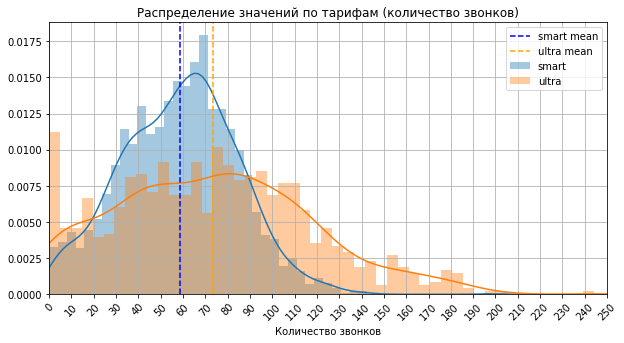

In [9]:
# количество звонков
two_hist(users_behavior, 'calls', 'количество звонков',
         xlabel='Количество звонков', xticks=np.arange(0, 251, 10), xlim=(0, 250))

- В целом **распределение** выборочных данных по тарифу **Смарт похоже на нормальное**: симметричность, пик в районе среднего. 
- Распределение по **Ультра** меньше похоже на нормальное: наблюдается более **широкий размах** и **отсутствие** такого же ярко выраженного **пика**. Возможно, проблема в том, что в рамках одного тарифа может быть несколько **разных групп клиентов**.
- Для **Ультра** наблюдается **околонулевой пик** для количества звонков **меньше 10**. Частично вклад в это могут вносить **нулевые звонки** - выше мы уже выяснили, что **большинство** нулевых звонков приходится на **Ультра**.  

#### 2. Длительность звонков

Изучим данные по суммарной длительности звонков для каждого из тарифов:

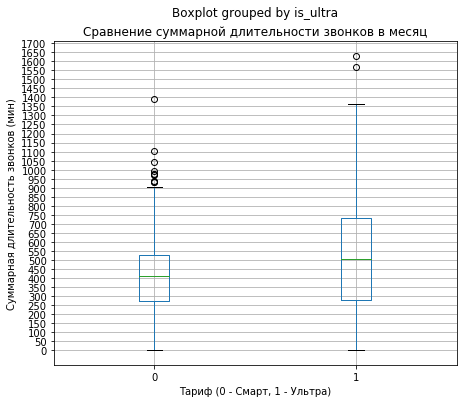

,count,mean,std,min,25%,50%,75%,max
is_ultra,,,,,,,,
0,2229.0,405.942952,184.512604,0.0,274.23,410.56,529.51,1390.22
1,985.0,511.224569,308.031100,0.0,276.03,502.55,730.05,1632.06


In [10]:
# длительность звонков
box_describe(users_behavior, 'minutes', 'is_ultra', title='Сравнение суммарной длительности звонков в месяц',
             ylabel='Суммарная длительность звонков (мин)', yticks=[i*50 for i in range(35)])

- Как и в предыдущем случае, в выборочных данных **размах шире** для пользователей **Ультра**: длительность половины звонков **от 276 до 730 минут**. Первый квартиль для **Смарт** практически на там же уровне **(274 минуты)**, половина звонков приходится на промежуток **от 274 до 529 минут**.

- В выборке по обоим тарифам **мало выбросов**. **Среднее** и **медиана** достаточно похожи: **511 и 503 минуты** соответственно для тарифа **Ультра**; **406 и 410 минут** для тарифа **Смарт**.

- **Минимальное значение** для обоих тарифов **0 минут** - это говорит о том, что клиент не пользовался звонками в этот месяц. 

- **Максимальное значение** для тарифа **Ультра** - это **1632 минуты**, а для **Смарт** - это **1390 минут**.  
То есть в выборке **нет** пользователей с тарифом **Ультра**, которые разговаривали бы **сверх бесплатного лимита** (3000 минут), но есть пользователи **Смарт**, которые значительно превысили бесплатный лимит (500 минут).

Ранее мы уже проверили количество нулевых звонков *calls*.  
Можем дополнительно проверить это для *minutes* - результат должен получиться таким же.

In [11]:
# длительность звонков
zero_count(users_behavior, 'minutes', 'длительность звонков')
print()

# дополнительная проверка на отсутствие строк, где minutes 0, но calls не 0 и наоборот
print(users_behavior.query('minutes==0 and calls!=0'))
print(users_behavior.query('minutes!=0 and calls==0'))

Количество нулевых значений (длительность звонков): 40
Количество нулевых значений, тариф Ультра (длительность звонков): 34
Количество нулевых значений, тариф Смарт (длительность звонков): 6

Empty DataFrame
Columns: [calls, minutes, messages, mb_used, is_ultra]
Index: []
Empty DataFrame
Columns: [calls, minutes, messages, mb_used, is_ultra]
Index: []


Всё верно, результат тот же, некорректных строк (где *minutes* 0, но *calls* не 0 и наоборот) нет.

Посмотрим на распределение данных на гистограмме:

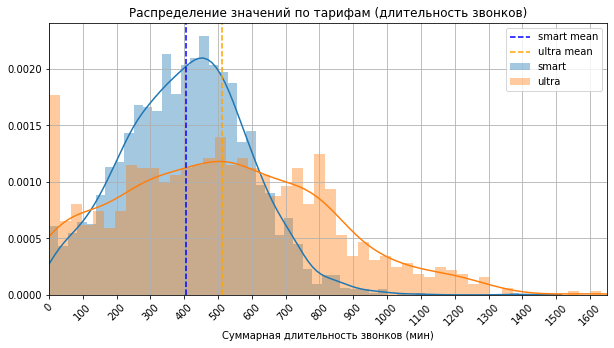

In [12]:
# длительность звонков
two_hist(users_behavior, 'minutes', 'длительность звонков',
         xlabel='Суммарная длительность звонков (мин)', xticks=np.arange(0, 1701, 100), xlim=(0, 1650))

- Как и в предыдущем случае, **распределение** выборочных данных по тарифу **Смарт** больше похоже на **нормальное**.
- Для распределения **Ультра** есть подозрения относительно наличия **нескольких подгрупп** в выборке.
- Для **Ультра** характерен более **широкий размах** и **околонулевой пик**.

Также будет интересно посмотреть, как соотносятся между собой **количество звонков *calls*** и **суммарная продолжительность звонков *minutes***:

Коэффициент корреляции для calls и minutes (Смарт): 97.27%
Коэффициент корреляции для calls и minutes (Ультра): 98.82%


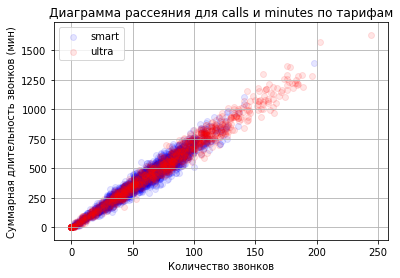

In [13]:
# срезы по тарифам
smart_users = users_behavior.query('is_ultra == 0')
ultra_users = users_behavior.query('is_ultra == 1')

# расчёт коэффициента корреляции
print('Коэффициент корреляции для calls и minutes (Смарт): {:.2%}'
      .format(smart_users['calls'].corr(smart_users['minutes'])))

print('Коэффициент корреляции для calls и minutes (Ультра): {:.2%}'
      .format(ultra_users['calls'].corr(ultra_users['minutes'])))

# построение scatter plot
plt.scatter(x = smart_users['calls'], y = smart_users['minutes'], alpha=0.1, c='blue', label='smart')
plt.scatter(x = ultra_users['calls'], y = ultra_users['minutes'], alpha=0.1, c='red', label='ultra')

plt.title('Диаграмма рассеяния для calls и minutes по тарифам')
plt.xlabel('Количество звонков')
plt.ylabel('Суммарная длительность звонков (мин)')

plt.legend()
plt.grid()
plt.show()

- В обоих случаях для **количества** и **суммарной продолжительности звонков** очень высокое значение **коэффициента корреляции**, что говорит о **сильной положительной зваимосвязи** (порядка 97% для Смарт и 98% для Ультра).  
- Это выглядит довольно логично: **много минут разговора** получается в результате **большого количества звонков**, и наоборот, для **большого количества звонков** характерны **высокие** показатели **количества минут** в месяц.
- Два фактора очень сильно взаимосвязаны, т. е. можно говорить об **мультиколлинеарности** переменных. Потенциально можно отказаться от одного из факторов.

#### 3. Количество sms-сообщений

Изучим данные по количеству sms-сообщений для каждого из тарифов:

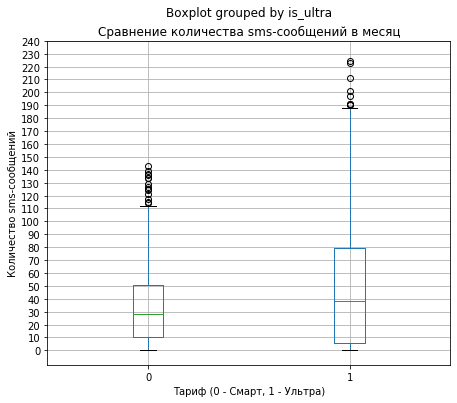

,count,mean,std,min,25%,50%,75%,max
is_ultra,,,,,,,,
0,2229.0,33.384029,28.227876,0.0,10.0,28.0,51.0,143.0
1,985.0,49.363452,47.804457,0.0,6.0,38.0,79.0,224.0


In [14]:
# количество sms
box_describe(users_behavior, 'messages', 'is_ultra', title='Сравнение количества sms-сообщений в месяц',
             ylabel='Количество sms-сообщений', yticks=np.arange(0, 241, 10))

- Снова для более дорогого тарифа **Ультра** характерен и более широкий размах: в половине случаев **от 6 до 79 сообщений**. Для **Смарт** этот показатель **от 10 до 51 сообщений**.
- Как и в предыдущих случаях, встречаются выбросы в большую сторону. Значение **среднего** несколько больше значения **медианы**: **33 и 28 сообщений** соответственно для **Смарт**, **49 и 38 сообщений** для **Ультра**.
- Встречается **минимальное значение ноль** - значит, смс не использовались в этом месяце.
- **Максимальное значение** в выборке для **Смарт** - **143 сообщения** (бесплатный лимит 50 сообщений), для **Ультра** - **224 сообщения** (бесплатный лимит 1000 сообщений).

Посмотрим, сколько всего в выборке нулевых сообщений, т. е. *messages* равно 0:

In [15]:
# количество sms
zero_count(users_behavior, 'messages', 'сообщения')

Количество нулевых значений (сообщения): 497
Количество нулевых значений, тариф Ультра (сообщения): 190
Количество нулевых значений, тариф Смарт (сообщения): 307


- По выборочным данным, сообщения **менее востребованный** способ связи, чем звонки.
- В данных **497 строк с нулями**, что составляет **15% строк** от общего числа строк.

Посмотрим на распределение данных на гистограмме:

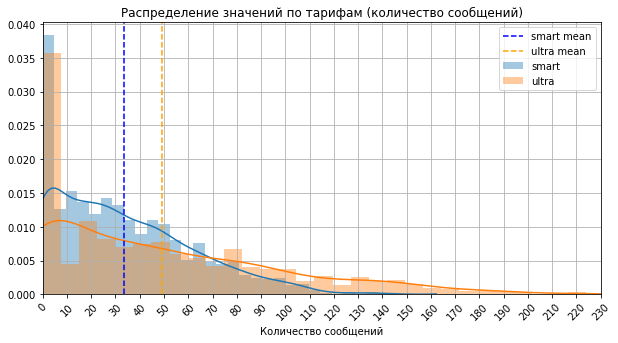

In [16]:
# длительность звонков
two_hist(users_behavior, 'messages', 'количество сообщений',
         xlabel='Количество сообщений', xticks=np.arange(0, 241, 10), xlim=(0, 230), n_bins=30)

- Данные по обоим тарифам распределены **несимметрично**, наблюдается пик **околонулевых** значений (вклад в это вносят непосредственно сами **нулевые** значения).

#### 4. Количество использованных mb (мобильный интернет)

Изучим данные по использованию мобильного интернета для каждого из тарифов:

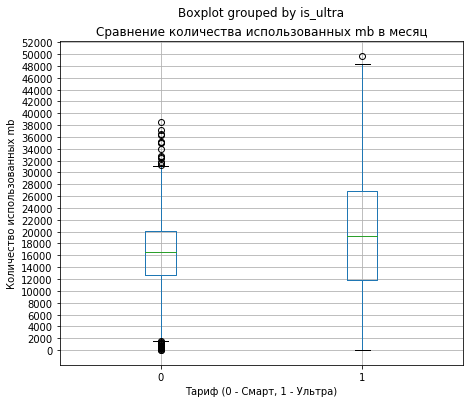

,count,mean,std,min,25%,50%,75%,max
is_ultra,,,,,,,,
0,2229.0,16208.466949,5870.498853,0.0,12643.05,16506.93,20043.06,38552.62
1,985.0,19468.823228,10087.178654,0.0,11770.28,19308.01,26837.72,49745.73


In [17]:
# мобильный интернет
box_describe(users_behavior, 'mb_used', 'is_ultra', title='Сравнение количества использованных mb в месяц',
             ylabel='Количество использованных mb', yticks=[i*2000 for i in range(27)])

- И снова для тарифа **Ультра** характерен и более **широкий размах**: в половине случаев было использовано **от 11.7 до 26.8 Гб**, т. е. обычно люди укладываются в бесплатный лимит. Для **Смарт** этот показатель **от 12.6 до 20 Гб** при бесплатном лимите **15 Гб**.
- Для **Смарт** показаны выбросы **в обе стороны**: как в большую, так и в меньшую. Для **Ультра** в выбросы попало только **одно** значение, которое является **масимумом** в выбранных данных - **49.7 Гб**.
- **Среднее** и **медиана** внутри тарифов достаточно похожи: для **Ультра** это **19.5 и 19.3 Гб** соответственно, для **Смарт** - **16.2 и 16.5 Гб**.
- В обоих случаях **минимальное значение ноль** - значит, в этом месяце не было использования мобильного интернета.
- **Максимальное значение** в выборке для **Смарт** - **38.5 Гб** (бесплатный лимит 15 Гб), для **Ультра** - **49.7 Гб** (бесплатный лимит 30 Гб).

Посмотрим, сколько всего в выборке нулевых mb, т. е. *mb_used* равно 0:

In [18]:
# мобильный интернет
zero_count(users_behavior, 'mb_used', 'использовано Мб')

Количество нулевых значений (использовано Мб): 11
Количество нулевых значений, тариф Ультра (использовано Мб): 10
Количество нулевых значений, тариф Смарт (использовано Мб): 1


- Любопытно, что в нашей выборке присутствует **11 нулевых значений**, из которых **10 значений** приходится на более дорогой тариф **Ультра**, где в пакет включено целых **30 Гб мобильного интернета**.

Посмотрим на распределение данных на гистограмме.

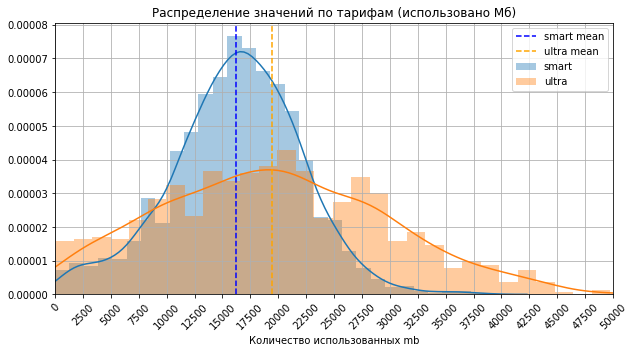

In [19]:
# мобильный интернет
two_hist(users_behavior, 'mb_used', 'использовано Мб',
         xlabel='Количество использованных mb', xticks=[i*2500 for i in range(22)], xlim=(0, 50000), n_bins=30)

- **Распределение** выборочных данных по тарифам **похоже на нормальное**, особенно для **Смарт**: симметричность, выраженный пик в районе среднего.
- В **Ультра** более **широкое распределение**, менее ярковыраженный **пик**, но, в отличие от предыдущих случаев, отсутствует пик в районе **околонулевых значений**.

#### 5. Матрица корреляций по тарифам

Мы рассмотрели данные по звонкам, сообщениям и мобильному интернету по каждому из тарифов. Ранее мы уже изучили взаимосвязь между **количеством** и **суммарной продолжительностью** звонков. Дополнительно посмотрим на взаимосвязь между всеми переменными. Возможно, мы найдем ещё какую-нибудь интересную взаимосвязь.

In [20]:
def cor_scatter_matrix(df_name, mob_plan_name):
    
    """Функция возвращает матрицу корреляций и визуализацию матрицы корреляций:
    - df_name - наименование датафрейма;
    - mob_plan_name - наименование тарифа."""

    # срез
    df_matrix = df_name.drop(['is_ultra'], axis=1)
    
    # визуализация матрицы корреляций
    _ = pd.plotting.scatter_matrix(df_matrix, figsize=[8, 8], alpha=0.4)
    plt.suptitle(f'Визуализация матрицы корреляций, тариф {mob_plan_name}')
    plt.show()
    
    # матрица с корреляциями
    return  df_matrix.corr()

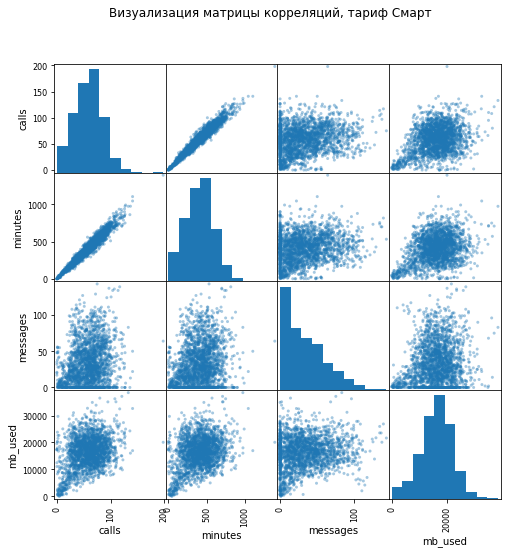

,calls,minutes,messages,mb_used
calls,1.000000,0.972654,0.208789,0.357349
minutes,0.972654,1.000000,0.203746,0.341639
messages,0.208789,0.203746,1.000000,0.146499
mb_used,0.357349,0.341639,0.146499,1.000000


In [21]:
# тариф Смарт
cor_scatter_matrix(smart_users, 'Смарт')

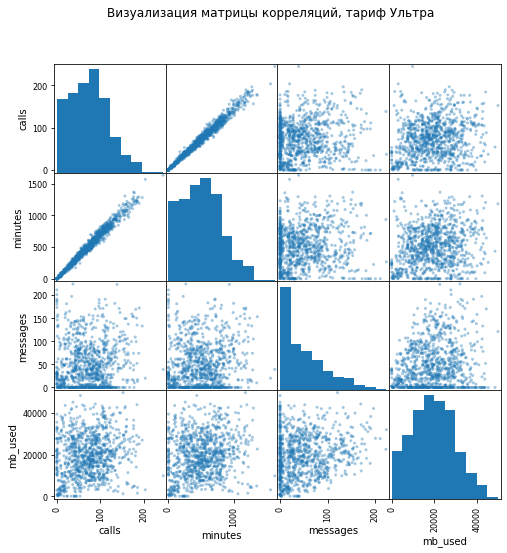

,calls,minutes,messages,mb_used
calls,1.000000,0.988235,0.087691,0.176856
minutes,0.988235,1.000000,0.083000,0.178003
messages,0.087691,0.083000,1.000000,0.173710
mb_used,0.176856,0.178003,0.173710,1.000000


In [22]:
# тариф Ультра
cor_scatter_matrix(ultra_users, 'Ультра')

- Для тарифа **Смарт** наблюдается некоторая взаимосвязь между **использованием Мб** и **звонками и продолжительностью звонков** (значение корреляции 0.36 и 0.34 соответственно).
- Для тарифа **Ультра** не наблюдается каких-либо ярко выраженных взаимосвязей между звонками, сообщениями и мобильным интернетом: во всех случаях коэффициент корреляции **на уровне 0.17**.

## Шаг 1. Вывод

Мы ознакомились с полученными данными и изучили их:  

#### Открытие файла
 - Файл содержит **3214 строк и 5 столбцов**. Столбец *is_ultra* указывает на тариф. **Остальные** - на расход услуг в течение месяца: *calls* - количество звонков; *minutes* - продолжительность звонков; *messages* - количество sms; *mb_used* - использование Мб.
 - Данные уже **предобработаны** и не содержат пропусков.
    
#### Изучение файла
 - Во всех случаях (звонки, сообщения, мобильный интернет) встречаются **нулевые значения** - т. е. в данном месяце услугой не пользовались.
 - По всем видам связи размах для тарифа **Ультра шире**, чем для тарифа **Смарт**. 
 - Распределение данных в случае **количества сообщений** по **обоим** тарифам **не нормальное**: оно не симметрично и, скорее, напоминает экспоненциальное распределение. 
 - Помимо сообщений, в остальных случаях **распределение данных** для **Смарт** похоже на **нормальное**: оно унимодально, симметрично с пиком в районе среднего.
 - Помимо сообщений, распределение **Ультра** меньше похоже на **нормальное**, чем **Смарт**: оно более **широкое**, имеет **менее** ярко выраженный пик в районе среднего. В случае со **звонками** наблюдается **околонулевой пик**. Есть подозрение, что **Ультра** содержит несколько **отдельных подгрупп** в рамках выборки.
 - При изучении взаимосвязи между звонками, сообщениями и мобильным интернетом по тарифам каких-либо **сильных взаимосвязей не обнаружено**. Для Смарт есть некоторая взаимосвязь между **использованием Мб** и **звонками и продолжительностью звонков** (значение корреляции **0.36 и 0.34** соответственно). Для **Ультра** во всех случаях **коэффициент корреляции на уровне 0.17**.

## Шаг 2. Исследование моделей

На данном шаге будет исследовано несколько моделей с различными гиперпараметрами:
- [1. Решающее дерево (DecisionTreeClassifier)](#1.-Решающее-дерево-(DecisionTreeClassifier))
- [2. Случайный лес (RandomForestClassifier)](#2.-Случайный-лес-(RandomForestClassifier))
- [3. Логистическая регрессия (LogisticRegression)](#3.-Логистическая-регрессия-(LogisticRegression))

Разделим исходные данные на **обучающую, валидационную** и **тестовую выборки**:

In [23]:
SEED = 12345

# обучающая - train, валидационная + тестовая - df_valid_test
df_train, df_valid_test = train_test_split(users_behavior, test_size=0.4, random_state=SEED)

# валидационная - valid, тестовая - test
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=SEED)

print('Всего объектов в выборке:', len(users_behavior))
print('Количество объектов в обучающей выборке:', len(df_train))
print('Количество объектов в валидационной выборке:', len(df_valid))
print('Количество объектов в тестовой выборке:', len(df_test))

Всего объектов в выборке: 3214
Количество объектов в обучающей выборке: 1928
Количество объектов в валидационной выборке: 643
Количество объектов в тестовой выборке: 643


Исходя из того, сколько **минут, sms и Мб** использует в месяц клиент, мы должны предложить ему либо тариф **Смарт**, либо тариф **Ультра**. Значит, мы должны решить задачу по **классификации**.

Выделим **признаки (features)** и **целевой признак (target)** для наших данных:   
- **Признаки** - это использование услуг в течение месяца (количество звонков и их продолжительность, количество смс, использование Мб).
- **Целевой признак** - это наиболее **подходящий тариф** (Смарт либо Ультра).

In [24]:
# выделение признаков и целевого признака из обучающей выборки
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

# выделение признаков и целевого признака из валидационной выборки
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

# выделение признаков и целевого признака из тестовой выборки
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

Сначала проверим, какие результаты выдаст **константная модель**. Укажем в качестве предсказаний **наиболее часто встречающийся** ответ (в данном случае 0 - тариф Смарт) и измерим значение *accuracy* для предсказаний:

In [25]:
# измерение accuracy константной модели
accuracy_constant = accuracy_score(users_behavior['is_ultra'], np.zeros(len(users_behavior)))
print('Значение accuracy (константная модель):', accuracy_constant)

Значение accuracy (константная модель): 0.693528313627878


Если значение *accuracy* исследуемой модели **ниже 0.6935**, значит, она предсказывает **хуже**, чем просто замена на наиболее популярное значение.

### 1. Решающее дерево (DecisionTreeClassifier)

**Решающее дерево** является одной из базовых моделей.  
Поскольку размеры относительно небольшие, подберем гиперпараметры с помощью техники *GridSearchCV*:

In [26]:
%%time
# решётка с гиперпараметрами
param_grid = {'max_depth': np.arange(1, 11),
              'min_samples_leaf': [0.02, 0.04, 0.06, 0.08],
              'class_weight': [None, 'balanced']}

# обучение модели
dt = DecisionTreeClassifier(random_state=SEED)
dt_cv = GridSearchCV(dt, param_grid, cv=6, scoring='accuracy')
dt_cv.fit(features_train, target_train)

print("Лучшая комбинация: {}".format(dt_cv.best_params_))
print("Лучшее значение accuracy: {}".format(dt_cv.best_score_))

Лучшая комбинация: {'class_weight': None, 'max_depth': 3, 'min_samples_leaf': 0.02}
Лучшее значение accuracy: 0.8029046780570551
Wall time: 4.99 s


- Рекомендуемые параметры ***'min_samples_leaf': 0.02, 'max_depth': 3, 'class_weight': None***
- Наилучший результат *accuracy*: ***0.8029***

Используем эти гиперпараметры при сравнении моделей на этапе тестирования.

### 2. Случайный лес (RandomForestClassifier)

Посмотрим, какие результаты получатся при использовании **случайного леса**. В отличие от решающего дерева, алгоритм обучает несколько независимых деревьев и усредняет полученные результаты. В данном случае, чтобы сэкономить время, подберём гиперпараметры с помощью *RandomizedSearchCV*:

In [27]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(10, 71, 10),
              'max_depth': np.arange(1, 7),
              'class_weight': [None, 'balanced']}

# обучение модели
rf = RandomForestClassifier(random_state=SEED)
rf_cv = RandomizedSearchCV(rf, param_grid, cv=6, scoring='accuracy', random_state=SEED)
rf_cv.fit(features_train, target_train)

print("Лучшая комбинация: {}".format(rf_cv.best_params_))
print("Лучшее значение accuracy: {}".format(rf_cv.best_score_))

Лучшая комбинация: {'n_estimators': 50, 'max_depth': 6, 'class_weight': None}
Лучшее значение accuracy: 0.8112039885709126
Wall time: 10.8 s


- Рекомендуемые параметры: ***'n_estimators': 50, 'max_depth': 6, 'class_weight': None***
- Наилучший результат *accuracy*: ***0.8112***

### 3. Логистическая регрессия (LogisticRegression)

Плюс логистической модели в её **скорости** и относительно **небольшой вероятности переобучения**. Применим к нашим данным эту модель и посмотрим на получившийся результат. Для подбора параметров будем использовать *GridSearchCV*:

In [28]:
%%time
# способ с RandomizedSearchCV
# решётка с гиперпараметрами
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': np.arange(10, 26, 5),
              'class_weight': [None, 'balanced'],
              'solver': ['liblinear', 'saga']}

# обучение модели
lr = LogisticRegression(random_state=SEED)
lr_cv = GridSearchCV(lr, param_grid, cv=6, scoring='accuracy')
lr_cv.fit(features_train, target_train)

print("Лучшая комбинация: {}".format(lr_cv.best_params_))
print("Лучшее значение accuracy: {}".format(lr_cv.best_score_))

Лучшая комбинация: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшее значение accuracy: 0.7531104274298097
Wall time: 6.58 s


- Рекомендуемые параметры: ***'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 10***
- Наилучший результат *accuracy*: ***0.7531***
- Значение *accuracy* ниже, чем у предыдущих двух моделей, но не ниже бенчмарка ***0.75***

## Шаг 2. Вывод

Мы рассмотрели несколько моделей с различными гиперпараметрами: **решающее дерево**, **случайный лес** и **логистическую регрессию**.  
Также мы изучили результаты *accuracy* в случае замены предсказаний **константой**.

- **Константная модель**
  - Значение *accuracy*: ***0.6935***
  - Если *accuracy* исследуемой модели **ниже 0.6935**, значит, она предсказывает **хуже**, чем просто замена на наиболее популярное значение.


- **Решающее дерево**
  - Рекомендуемые параметры ***'min_samples_leaf': 0.02, 'max_depth': 3, 'class_weight': None***
  - Наилучший результат *accuracy*: ***0.8029***
 
    
- **Случайный лес**
  - Рекомендуемые параметры: ***'n_estimators': 50, 'max_depth': 6, 'class_weight': None***
  - Наилучший результат *accuracy*: ***0.8112***
    
    
- **Логистическая регрессия**
  - Рекомендуемые параметры: ***'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 10***
  - Наилучший результат *accuracy*: ***0.7531***
  - Значение *accuracy* ниже, чем у предыдущих двух моделей, но не ниже бенчмарка ***0.75***

## Шаг 3. Проверка моделей на тестовой выборке

С помощью цикла проверим модели на **тестовой выборке**:

In [29]:
dt = DecisionTreeClassifier(random_state=SEED, min_samples_leaf=0.02, max_depth=3, class_weight=None)
rf = RandomForestClassifier(random_state=SEED, n_estimators=50, max_depth=6, class_weight=None)
lr = LogisticRegression(random_state=SEED, solver='liblinear', penalty='l1', class_weight=None, C=10)

model_dict = {'DecisionTreeClassifier': dt, 'RandomForestClassifier': rf, 'LogisticRegression': lr}

for model_name in model_dict.keys():
    model = model_dict[model_name]
    model.fit(features_train, target_train)
    predictions_test = model.predict(features_test)
    accuracy_test = accuracy_score(target_test, predictions_test)
    print(f"Тестовая выборка accuracy {model_name}:", accuracy_test)

Тестовая выборка accuracy DecisionTreeClassifier: 0.7791601866251944
Тестовая выборка accuracy RandomForestClassifier: 0.7931570762052877
Тестовая выборка accuracy LogisticRegression: 0.7465007776049767


- На тестовой выборке для *DecisionTreeClassifier* и *RandomForestClassifier* результат получился **не менее 0.77**.
- Для *LogisticRegression* результат получился немного **меньше** установленного порога **0.75.**
- Наилучший результат на тестовой выборке показала модель **случайный лес** с гиперпараметрами ***n_estimators=20, min_samples_leaf=0.02, max_depth=4, class_weight=None***. Результат *accuracy* на тестовой выборке - ***0.7931***.

## Шаг 3. Вывод
    
Была проведена проверка выбранных моделей на **тестовой выборке**:
- На тестовой выборке для *DecisionTreeClassifier* и *RandomForestClassifier* результат получился **не менее 0.77**.
- Для *LogisticRegression* результат получился немного **меньше** установленного порога **0.75.**
- Наилучший результат на тестовой выборке показала модель **случайный лес** с гиперпараметрами ***n_estimators=20, min_samples_leaf=0.02, max_depth=4, class_weight=None***. Результат *accuracy* на тестовой выборке - ***0.7931***.

# Итоговый вывод

## Шаг 1. Открытие и изучение файла 

#### Открытие файла
 - Файл содержит **3214 строк и 5 столбцов**. Столбец *is_ultra* указывает на тариф. **Остальные** - на расход услуг в течение месяца: *calls* - количество звонков; *minutes* - продолжительность звонков; *messages* - количество sms; *mb_used* - использование Мб.
 - Данные уже **предобработаны** и не содержат пропусков.
    
#### Изучение файла
 - Во всех случаях (звонки, сообщения, мобильный интернет) встречаются **нулевые значения** - т. е. в данном месяце услугой не пользовались.
 - По всем видам связи размах для тарифа **Ультра шире**, чем для тарифа **Смарт**. 
 - Распределение данных в случае **количества сообщений** по **обоим** тарифам **не нормальное**: оно не симметрично и, скорее, напоминает экспоненциальное распределение. 
 - Помимо сообщений, в остальных случаях **распределение данных** для **Смарт** похоже на **нормальное**: оно унимодально, симметрично с пиком в районе среднего.
 - Помимо сообщений, распределение **Ультра** меньше похоже на **нормальное**, чем **Смарт**: оно более **широкое**, имеет **менее** ярко выраженный пик в районе среднего. В случае со **звонками** наблюдается **околонулевой пик**. Есть подозрение, что **Ультра** содержит несколько **отдельных подгрупп** в рамках выборки.
 - При изучении взаимосвязи между звонками, сообщениями и мобильным интернетом по тарифам каких-либо **сильных взаимосвязей не обнаружено**. Для Смарт есть некоторая взаимосвязь между **использованием Мб** и **звонками и продолжительностью звонков** (значение корреляции **0.36 и 0.34** соответственно). Для **Ультра** во всех случаях **коэффициент корреляции на уровне 0.17**.
    
## Шаг 2. Исследование моделей
Мы рассмотрели несколько моделей с различными гиперпараметрами: **решающее дерево**, **случайный лес** и **логистическую регрессию**.  
Также мы изучили результаты *accuracy* в случае замены предсказаний **константой**.

- **Константная модель**
  - Значение *accuracy*: ***0.6935***
  - Если *accuracy* исследуемой модели **ниже 0.6935**, значит, она предсказывает **хуже**, чем просто замена на наиболее популярное значение.

- **Решающее дерево**
  - Рекомендуемые параметры ***'min_samples_leaf': 0.02, 'max_depth': 3, 'class_weight': None***
  - Наилучший результат *accuracy*: ***0.8029***
 
- **Случайный лес**
  - Рекомендуемые параметры: ***'n_estimators': 50, 'max_depth': 6, 'class_weight': None***
  - Наилучший результат *accuracy*: ***0.8112***
        
- **Логистическая регрессия**
  - Рекомендуемые параметры: ***'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 10***
  - Наилучший результат *accuracy*: ***0.7531***
  - Значение *accuracy* ниже, чем у предыдущих двух моделей, но не ниже бенчмарка ***0.75***
    
    
## 3. Проверка моделей на тестовой выборке
Была проведена проверка выбранных моделей на **тестовой выборке**:
- На тестовой выборке для *DecisionTreeClassifier* и *RandomForestClassifier* результат получился **не менее 0.77**.
- Для *LogisticRegression* результат получился немного **меньше** установленного порога **0.75.**
- Наилучший результат на тестовой выборке показала модель **случайный лес** с гиперпараметрами ***'n_estimators': 50, 'max_depth': 6, 'class_weight': None***. Результат *accuracy* на тестовой выборке - ***0.7931***.